<p style="text-align:center">
PSY 381D <b>Brain Connectivity</b>, Spring 2019


<img style="width: 700px; padding: 0px;" src="https://github.com/sathayas/JupyterConnectivitySpring2019/blob/master/Images/Banner.png?raw=true" alt="title pics"/>

</p>

<p style="text-align:center; font-size:40px; margin-bottom: 30px;"><b> Functional connectivity measures </b></p>

<p style="text-align:center; font-size:18px; margin-bottom: 32px;"><b>March 25, 2019</b></p>

<hr style="height:5px;border:none" />

# 1. Data

<hr style="height:1px;border:none" />

In the **`DataConnectivity`** directory, there is an mean ROI time series data set called **`Oxford_sub16112_rt2_K200.npz`**. It contains the time series data from ROIs defined by the Craddock atlas (R<sub>t</sub>, 2-level) with K=200. The file contains the following arrays:
  * **`ts`**: ROI time series (rows=time points, columns=ROIs)
  * **`nodes`**: A list of nodes (ROIs), in the same order as the columns in `ts`.
  * **`xyz`**: XYZ-coordinates of ROIs, in the same order as `nodes`.

# 2. Different connectivity measures and networks
<hr style="height:1px;border:none" />

Now, based on this time series data, let's construct networks formed by different connectivity  measures. But before that, here is some preparation work.

`<ConstructNetwork.py>`

In [2]:
%matplotlib inline

In [3]:
import os
import numpy as np
import nibabel as nib
import networkx as nx
import matplotlib.pyplot as plt

###### Parameters
targetDeg = 10  # target average degree
targetK = 200 # target K for the atlas
nBins = 11  # number of bins for mutual information


###### Loadin the data from the previous time
f_TS = 'DataConnectivity/Oxford_sub16112_Rt2_K' + str(targetK) + '.npz'
infile = np.load(f_TS)
ts = infile['ts']
nodes = infile['nodes']
xyz = infile['xyz']

## Correlation

Calculating a correlation matrix from a time series data is straightforward, as you saw in the previous class.

In [4]:
###### Calculating the correlation matrix
R = np.corrcoef(ts, rowvar=False)

# making the diagonal elements to zero
for iRow in range(R.shape[0]):
    R[iRow,iRow] = 0

## Partial correlation

A partial correlation is a variant of correlation. While a correlation between variables X and Y measures the linear association between these variables, a partial correlation between X and Y represents the linear association between them after association with all the other variables are removed.

For example, if variables A and B are correlated, and variables A and C are correlated. Then the variables B and C are likely correlated because of their correlation with A. In the partial correlation between B and C, the influence of A is removed, showing the true association between B and C not mediated by other variables (such as A).

Unfortunately there is no function to calculate partial correlations in Python. So I will use a function called **`partial_corr`** in a file **`partial_corr.py`** (written by Fabian Pedregosa-Izquierdo; already included in the repository). Since this is a custom function, you have to import it before you can use it. Its use if very similar to the correlation function, and it returns a partial correlation matrix. As you can see, the calculation of partial correlation is more computationally intensive than correlation. 

In [17]:
# importing external functions for MI and PC calculation
from partial_corr import partial_corr
    
###### Calculating the partial correlaiton matrix
Rpc = partial_corr(ts)

# making the diagonal elements to zero
for iRow in range(Rpc.shape[0]):
    Rpc[iRow,iRow] = 0

Working on row i: 0
Working on row i: 1
Working on row i: 2
Working on row i: 3
Working on row i: 4
Working on row i: 5
Working on row i: 6
Working on row i: 7
Working on row i: 8
Working on row i: 9
Working on row i: 10
Working on row i: 11
Working on row i: 12
Working on row i: 13
Working on row i: 14
Working on row i: 15
Working on row i: 16
Working on row i: 17
Working on row i: 18
Working on row i: 19
Working on row i: 20
Working on row i: 21
Working on row i: 22
Working on row i: 23
Working on row i: 24
Working on row i: 25
Working on row i: 26
Working on row i: 27
Working on row i: 28
Working on row i: 29
Working on row i: 30
Working on row i: 31
Working on row i: 32
Working on row i: 33
Working on row i: 34
Working on row i: 35
Working on row i: 36
Working on row i: 37
Working on row i: 38
Working on row i: 39
Working on row i: 40
Working on row i: 41
Working on row i: 42
Working on row i: 43
Working on row i: 44
Working on row i: 45
Working on row i: 46
Working on row i: 47
Wo

## Mutual information

Both correlation and partial correlation assume that the association is linear; when one variable increases, so does the other variables. However, that is just one possibility of describing how one variable associates with other variables. In fact, correlations may miss any relationships that are not linear.

<img style="width: 500px; padding: 0px;" src="https://github.com/sathayas/JupyterConnectivitySpring2019/blob/master/Images/Connectivity_correlation.png?raw=true" alt="correlation and when it fails"/>

Mutual information is a measure of association between two variables based on information theory. In brief, it summarizes how dependent two variables X and Y are, based on their joint distribution. It is sensitive to both linear and non-linear relationships. It ranges from 0 (no shared information) to 1 (information fully shared). 

Unfortunately there is no mutual information function in Python, so I have written a custom function called **`mutual_information`**, available in **`mutual_info.py`**. Its use is very similar to the correlation and partial correlation functions. You can provide the number of bins as a parameter in mutual information calculation (but I will skip the details). The function returns a matrix of mutual information between ROIs.

In [18]:
# importing external functions for MI and PC calculation
from mutual_info import mutual_information

###### Calculating the mutual information matrix
Rmi = mutual_information(ts, nBins)

## Constructing networks

Now that we have different association strength matrices, we can construct networks. We use the **`net_builder_HardTh`** function with target average degree of 10.

In [9]:
def net_builder_HardTh(R, NodeInd, K, cType=1):
    '''
    a function to construct the network by the hard-thresholding.
    input parameters:
          R:         A dense correlation matrix array.
          NodeInd:   A list of nodes in the network.
          K:         The target K, the average connections at each node
          cType:     Type of functional connectivity. 
                        1:  Positive correlation only
                        0:  Both positive and negative correlations
                        -1: Negative correlation only
                     The default is 1 (i.e., positive correlation only).
    
    returns:
          G:         The resulting graph (networkX format)
    '''
    
    # first, initialize the graph
    G = nx.Graph()
    G.add_nodes_from(NodeInd)
    NNodes = R.shape[0]
    # upper triangle of the correlation matrix only
    I,J = np.triu_indices(NNodes,1)
    # creating a vector of correlation coefficients, depending on cType
    if cType==1:
        VecR = np.squeeze(np.array(R[I,J]))
    elif cType==0:
        VecR = np.squeeze(np.array(abs(R[I,J])))
    elif cType==-1:
        VecR = np.squeeze(np.array(-R[I,J]))
    # the number of elements is too big, so we truncate it
    # first, find the appropriate threshold for R
    NthR = 0
    tmpRth = 0.95
    StepTh = 0.05
    while NthR<K*NNodes/2.0:
        tmpRth -= StepTh
        #print('Threshold = %.2f' % tmpRth)
        NthR = len(np.nonzero(VecR>tmpRth)[0])
    # second, truncate the variables
    IndVecR = np.nonzero(VecR>tmpRth)
    thVecR = VecR[IndVecR]
    thI = I[IndVecR]
    thJ = J[IndVecR]
    # sort the correlation values
    zipR = zip(thVecR, thI, thJ)
    zipsR = sorted(zipR, key = lambda t: t[0], reverse=True)
    sVecR, sI, sJ = zip(*zipsR)
    # then adding edges
    m = int(np.ceil(K*NNodes/2.0))  # the number of edges
    trI = np.array(sI[:m])
    trJ = np.array(sJ[:m])
    Elist = np.vstack((NodeInd[trI], NodeInd[trJ])).T
    G.add_edges_from(Elist)
    RTh = sVecR[m-1]  # the threshold
    # finally returning the resultant graph and the threshold
    return G


###### Thresholding
# Correlation
G = net_builder_HardTh(R, nodes, targetDeg)
# partial correlation
G_pc = net_builder_HardTh(Rpc, nodes, targetDeg)
# mutual information
G_mi = net_builder_HardTh(Rmi, nodes, targetDeg)
# and all together
G_all = [G, G_pc, G_mi]

Let's save the network data for future use.

In [10]:
###### writing network to a file
# Correlation
fNet = 'DataConnectivity/Oxford_sub16112_Rt2_K' + str(targetK)
fNet += '_deg' + str(targetDeg) + '.adjlist'
nx.write_adjlist(G, fNet)
# partial correlation
fNet = 'DataConnectivity/Oxford_sub16112_Rt2_K' + str(targetK)
fNet += '_deg' + str(targetDeg) + '_pc.adjlist'
nx.write_adjlist(G_pc, fNet)
# mutual information
fNet = 'DataConnectivity/Oxford_sub16112_Rt2_K' + str(targetK)
fNet += '_deg' + str(targetDeg) + '_mi.adjlist'
nx.write_adjlist(G_mi, fNet)

We can take a look at what these networks look like. 

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


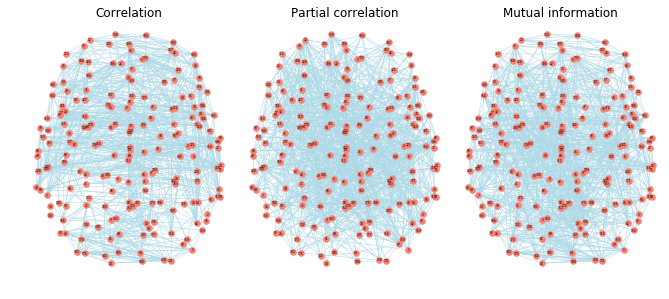

In [11]:
###### visualizing the networks
# dictionary of xy-coordinates
pos = {}
for iROI in range(len(nodes)):
    pos[nodes[iROI]] = xyz[iROI,:2]


# Loop over all graphs for visualization
connMethods = ['Correlation','Partial correlation','Mutual information']
plt.figure(figsize=[9,4])
for i in range(len(G_all)):


    # first, hard-thresholding network
    plt.subplot(1,3,i+1)
    nx.draw_networkx_nodes(G_all[i], pos, node_color='salmon',
                           node_size=30)
    nx.draw_networkx_edges(G_all[i], pos, width=0.5,
                           edge_color='lightblue')
    nx.draw_networkx_labels(G_all[i], pos, font_size=3, font_color='black')
    plt.title(connMethods[i])
    plt.axis('off')
    
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.06, bottom=0.025, top=0.90)
plt.show()

Differences may be hard to spot. But these networks have different properties. We shall see.

# 3. Network statistics
<hr style="height:1px;border:none" />

We can examine how these networks differ by using some of the techniques we have learned in this class so far. Let's examine the degree distributions first.

`<DegreeDist.py>`

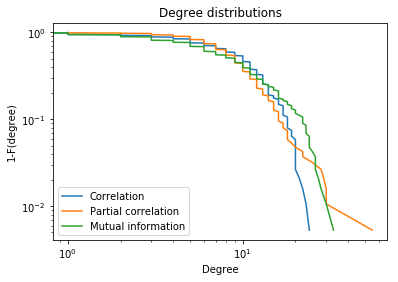

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

##### loading the network data
# correlatio network
G = nx.read_adjlist('DataConnectivity/Oxford_sub16112_Rt2_K200_deg10.adjlist',
                    nodetype=int)
# partial correlatio network
G_pc = nx.read_adjlist('DataConnectivity/Oxford_sub16112_Rt2_K200_deg10_pc.adjlist',
                       nodetype=int)
# mutual information network
G_mi = nx.read_adjlist('DataConnectivity/Oxford_sub16112_Rt2_K200_deg10_mi.adjlist',
                       nodetype=int)


##### Degree sequence
k = [d for n, d in G.degree()]
k_pc = [d for n, d in G_pc.degree()]
k_mi = [d for n, d in G_mi.degree()]


###### Cumulative distribution plots
sk = sorted(k, reverse=True) 
sk_pc = sorted(k_pc, reverse=True) 
sk_mi = sorted(k_mi, reverse=True) 


plt.plot(sk, np.arange(1,len(sk)+1)/len(sk), 
         label='Correlation')
plt.plot(sk_pc, np.arange(1,len(sk_pc)+1)/len(sk_pc), 
         label='Partial correlation')
plt.plot(sk_mi, np.arange(1,len(sk_mi)+1)/len(sk_mi), 
         label='Mutual information')
plt.title('Degree distributions')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('1-F(degree)')
plt.legend()
plt.show()


Very subtle but there are some differences at the tail of the distributions. The tail is longer for the partial correlation network. The mutual information network seems to have more higher-degree nodes than correlation network.

Now let's take a look at the clustering coefficients and path lengths (a.k.a., small-world metrics).

`<SmallWorldStats.py>`

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

##### loading the network data
# correlatio network
G = nx.read_adjlist('DataConnectivity/Oxford_sub16112_Rt2_K200_deg10.adjlist',
                    nodetype=int)
# partial correlatio network
G_pc = nx.read_adjlist('DataConnectivity/Oxford_sub16112_Rt2_K200_deg10_pc.adjlist',
                       nodetype=int)
# mutual information network
G_mi = nx.read_adjlist('DataConnectivity/Oxford_sub16112_Rt2_K200_deg10_mi.adjlist',
                       nodetype=int)


##### Clustering coefficients
print('Clustering coefficients')
print('Correlation network: %4.2f' % nx.average_clustering(G))
print('Partial correlation network: %4.2f' % nx.average_clustering(G_pc))
print('Mutual information network: %4.2f' % nx.average_clustering(G_mi))

Clustering coefficients
Correlation network: 0.46
Partial correlation network: 0.12
Mutual information network: 0.30


You notice right away that the clustering coefficient is very low for partial correlation network. This is because the partial correlation network contains far fewer triangles (say, compared to the correlation network). As I mentioned earlier, if A & B are correlated, and A & C are correlated, then B & C are likely correlated in a correlation network. On the other hand B & C are not connected unless they are truly correlated in a partial correlation network.

It looks like the mutual information network is somewhere in between the correlation network and the partial correlation network.

Now the path length (or the giant component).

In [16]:
##### giant components
GC_nodes = max(nx.connected_components(G), key=len)  # nodes in GC
GC = G.subgraph(GC_nodes)  # nodes & edges in giant component
GC_nodes_pc = max(nx.connected_components(G_pc), key=len)  # nodes in GC
GC_pc = G_pc.subgraph(GC_nodes_pc)  # nodes & edges in giant component
GC_nodes_mi = max(nx.connected_components(G_mi), key=len)  # nodes in GC
GC_mi = G_mi.subgraph(GC_nodes_mi)  # nodes & edges in giant component


##### Path Length
print('Average shortest path lengths (GC size)')
print('Correlation network: %4.2f' %
      nx.average_shortest_path_length(GC) + '(%d)' % len(GC_nodes))
print('Partial correlation network: %4.2f' %
      nx.average_shortest_path_length(GC_pc) + '(%d)' % len(GC_nodes_pc))
print('Mutual information network: %4.2f' %
      nx.average_shortest_path_length(GC_mi) + '(%d)' % len(GC_nodes_mi))

Average shortest path lengths (GC size)
Correlation network: 3.54(185)
Partial correlation network: 2.55(188)
Mutual information network: 2.92(186)


# 4. Modular organization
<hr style="height:1px;border:none" />

Now we see that networks formed by different connectivity measures have different structure, as you saw above. Now let's examine their modular organization to see if there are any difference between these networks formed with different connectivity measures. We shall use the Louvain method to find modular partitions.

`<Modularity.py>`

In [20]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import community   # Louvain method


##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


##### loading network data
# correlatio network
G = nx.read_adjlist('DataConnectivity/Oxford_sub16112_Rt2_K200_deg10.adjlist',
                    nodetype=int)
# partial correlatio network
G_pc = nx.read_adjlist('DataConnectivity/Oxford_sub16112_Rt2_K200_deg10_pc.adjlist',
                       nodetype=int)
# mutual information network
G_mi = nx.read_adjlist('DataConnectivity/Oxford_sub16112_Rt2_K200_deg10_mi.adjlist',
                       nodetype=int)
G_all = [G, G_pc, G_mi]
# time series data
f_TS = 'DataConnectivity/Oxford_sub16112_Rt2_K200.npz'
infile = np.load(f_TS)
nodes = infile['nodes']
xyz = infile['xyz']





##### Community detection 
# Community detection with the Louvain method
partition = community.best_partition(G)
partition_pc = community.best_partition(G_pc)
partition_mi = community.best_partition(G_mi)
partition_all = [partition, partition_pc, partition_mi]


###### Modularity
print('Modularity')
print('Correlaiton: %6.4f' % community.modularity(partition,G))
print('Partial correlaiton: %6.4f' % community.modularity(partition_pc,G_pc))
print('Mutal information: %6.4f' % community.modularity(partition_mi,G_mi))

Modularity
Correlaiton: 0.6054
Partial correlaiton: 0.3481
Mutal information: 0.4612


As you can see, the partial correlation network is not very modular. Since this network does not have many triangles, it may be difficult to form locally interconnected modules.

We can visualize modules too (in different colors).

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


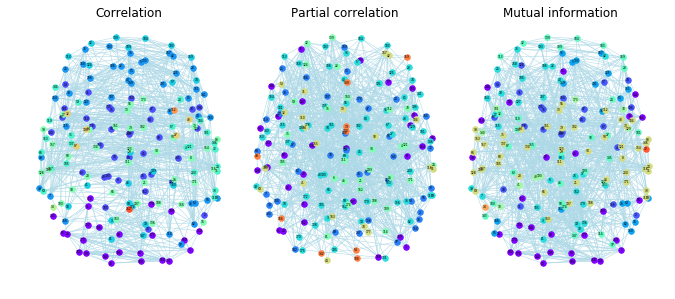

In [21]:
###### visualizing the networks
# dictionary of xy-coordinates
pos = {}
for iROI in range(len(nodes)):
    pos[nodes[iROI]] = xyz[iROI,:2]

# next, graph with communities in different colors 
connMethods = ['Correlation','Partial correlation','Mutual information']
plt.figure(figsize=[9,4])
for i in range(len(G_all)):
    plt.subplot(1,3,i+1)
    nComm = max([comm for comm in partition_all[i].values()])+1
    node_color_list = get_cmap(nComm+1,'rainbow')
    for iComm in range(nComm):
        nodeList = [iNode for iNode,Comm in partition_all[i].items()
                    if Comm==iComm]
        nx.draw_networkx_nodes(G_all[i], pos, 
                               nodelist=nodeList,
                               node_color = np.array([node_color_list(iComm)]),
                               node_size=30)
    nx.draw_networkx_edges(G_all[i], pos, width=0.5,
                           edge_color='lightblue')
    nx.draw_networkx_labels(G_all[i], pos, font_size=3, font_color='Black')
    plt.title(connMethods[i])
    plt.axis('off')

plt.subplots_adjust(left=0.01, right=0.99, wspace=0.06, bottom=0.025, top=0.90)
plt.show()

As you can see, modules appear somewhat random for the partial correlation network.

# 5. Enemy network
<hr style="height:1px;border:none" />

There is often a debate among neuroimaging researchers whether or not to include highly negative connection in a functional connectivity network, along with highly positive connectivity (as done typically). Just for fun, we can construct another version of a correlation network, but this time we only include highly negative correlations as edges (known as an enemy network). This can be done by flipping the sign on the correlation matrix.


`<ConstructNetworkNegative.py>`

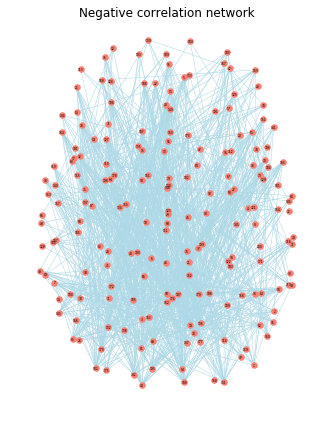

In [25]:
import os
import numpy as np
import nibabel as nib
import networkx as nx
import matplotlib.pyplot as plt

###### Parameters
targetDeg = 10  # target average degree
targetK = 200 # target K for the atlas

###### Loadin the data from the previous time
f_TS = 'DataConnectivity/Oxford_sub16112_Rt2_K' + str(targetK) + '.npz'
infile = np.load(f_TS)
ts = infile['ts']
nodes = infile['nodes']
xyz = infile['xyz']


###### Calculating the correlation matrix
R = np.corrcoef(ts, rowvar=False)

# flipping positive and negative
R = -R

# making the diagonal elements to zero
for iRow in range(R.shape[0]):
    R[iRow,iRow] = 0



###### Thresholding
# Correlation
G = net_builder_HardTh(R, nodes, targetDeg)


###### writing network to a file
# Correlation
fNet = 'DataConnectivity/Oxford_sub16112_Rt2_K' + str(targetK)
fNet += '_deg' + str(targetDeg) + '_negative.adjlist'
nx.write_adjlist(G, fNet)



###### visualizing the networks
# dictionary of xy-coordinates
pos = {}
for iROI in range(len(nodes)):
    pos[nodes[iROI]] = xyz[iROI,:2]


# Loop over all graphs for visualization
# first, hard-thresholding network
plt.figure(figsize=[5,7])
nx.draw_networkx_nodes(G, pos, node_color='salmon',
                       node_size=30)
nx.draw_networkx_edges(G, pos, width=0.5,
                       edge_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=3, font_color='black')
plt.title('Negative correlation network')
plt.axis('off')
plt.show()

### Exercise
1. **Clustering coefficient, negative correlation network**. Calculate the clustering coefficient of the negative correlation network. (Post the number on Canvas). Can you guess why you encountered such a result?

# *Further readings*
<hr style="height:1px;border:none" />

* Hartman D, Hlinka J, Palus M, Mantini D, Corbetta M. 2011. The role of nonlinearity in computing graph-theoretical properties of resting-state functional magnetic resonance imaging brain networks. Chaos. 21:013119. 
* Pritchard WS, Laurienti PJ, Burdette JH, Hayasaka S. 2014. Functional brain networks formed using cross-sample entropy are scale free. Brain Connectivity 4:454-64. 